In [415]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

In [416]:
# Most of this code is NOT my own work
# Utilizing code from https://github.com/SylCard/Spotify-Emotions-Project/blob/master/Clustering_Spotify_Songs.ipynb

In [417]:
import spotipy
import pandas as pd
import random
import json
import time
def get_user_token(username: str, scope: str, redirect_uri: str) -> str:
    """get token for specified user via credentials"""
    with open("../credentials/spotify_credentials.json", "r") as file:
        creds = json.load(file)
    return spotipy.util.prompt_for_user_token(username, scope, creds['CLIENT_ID'], creds['CLIENT_SECRET'],
                                              redirect_uri)
def authenticate_spotify(token: str) -> spotipy.Spotify:
    """authenticates Spotify account via the passed in token"""
    print('...connecting to Spotify')
    sp = spotipy.Spotify(auth=token)
    if sp:
        print('Connected to Spotify!')
    else:
        print('Unable to connect to Spotify.')
    return sp


def get_track_features(track_id: str, sp: spotipy.Spotify):
    """get dict of track features"""
    if track_id is None:
        return None
    else:
        features = sp.audio_features([track_id])
    return features


def get_tracks_with_features(tracks: list, sp: spotipy.Spotify) -> list:
    """return list of dicts with track info and features"""
    tracks_with_features = []
    #tracks = [] list input
    for track in tracks:
        #print(track)
        features = get_track_features(track['id'], sp)
        if features:
            f = features[0]
            tracks_with_features.append(dict(
                                            id=track['id'],
                                            artist=track['artist'],
                                            name=track['name'],
                                            danceability=f['danceability'],
                                            instrumentalness=f['instrumentalness'],
                                            energy=f['energy'],
                                            loudness=f['loudness'],
                                            speechiness=f['speechiness'],
                                            acousticness=f['acousticness'],
                                            tempo=f['tempo'],
                                            liveness=f['liveness'],
                                            valence=f['valence']
                                            ))
    return tracks_with_features


def get_all_tracks_from_playlists(username: str, sp: spotipy.Spotify) -> list:
    print('...getting all tracks from playlists')
    playlists = sp.user_playlists(username)
    trackList = []
    for playlist in playlists['items']:
        if playlist['owner']['id'] == username:
            print(playlist['name'], ' no. of tracks: ', playlist['tracks']['total'])
            results = sp.user_playlist(username, playlist['id'], fields="tracks,next")
            tracks = results['tracks']
            for i, item in enumerate(tracks['items']):
                track = item['track']
                trackList.append(dict(id=track['id'], artist=track['artists'][0]['name'], name=track['name']))
    return trackList


def get_top_artists(sp: spotipy.Spotify, amount: int = 25) -> list:
    """compiles list of user's top artists of length amount"""
    print('...getting top artists')
    artists_name = []
    artists_uri = []
    ranges = ['short_term', 'medium_term', 'long_term']
    for r in ranges:
        all_top_artist_data = sp.current_user_top_artists(limit=amount, time_range=r)
        top_artist_data = all_top_artist_data['items']
        for artist_data in top_artist_data:
            if artist_data['name'] not in artists_name:
                artists_name.append(artist_data['name'])
                artists_uri.append(artist_data['uri'])
    return artists_uri


def get_top_and_similar_artists(sp: spotipy.Spotify, amount: int = 25) -> list:
    """compiles a list of top and similar artists of length amount"""
    print('...getting top and similar artists')
    artists_name = []
    artists_uri = []
    ranges = ['short_term', 'medium_term', 'long_term']
    for r in ranges:
        all_top_artist_data = sp.current_user_top_artists(limit=amount, time_range=r)
        top_artist_data = all_top_artist_data['items']
        for artist_data in top_artist_data:
            if artist_data['name'] not in artists_name and len(artists_uri) < amount:
                artists_name.append(artist_data['name'])
                artists_uri.append(artist_data['uri'])
                similar_artists_data = sp.artist_related_artists(artist_id=artist_data['uri'])
                for index, similar_artist_data in enumerate(similar_artists_data['artists']):
                    if similar_artist_data['name'] not in artists_name and len(artists_uri) < amount:
                        artists_name.append(similar_artist_data['name'])
                        artists_uri.append(similar_artist_data['uri'])
                    if index == 2:
                        break
    return artists_uri


def get_artists_top_tracks(sp: spotipy.Spotify, artists_uri: list, amount: int = 50) -> list:
    """compiles unordered list of top tracks made by artists in artists_uri of length amount"""
    print('...getting top tracks for each artist')
    tracks = []
    for artist in artists_uri:
        all_top_tracks_data = sp.artist_top_tracks(artist)
        top_tracks_data = all_top_tracks_data['tracks']
        for track_data in top_tracks_data:
            tracks.append(dict(id=track_data['id'], artist=track_data['artists'][0]['name'], name=track_data['name']))
            #print('track    : ' + track_data['name'])
            #print('artist    : ' + track_data['artists'][0]['name'])
            #print('id ' + track_data['id'])
            #print()
            #tracks.append(track_data)
    #random.shuffle(tracks)
    #tracks = tracks[0:amount]
    return tracks


def create_playlist(sp: spotipy.Spotify, tracks: list, playlist_name: str, amount: int = 0):
    """creates a playlist or tracks from tracks_uri on the users account of length amount"""
    print('...creating playlist')
    if amount == 0:
        amount = len(tracks)
    user_id = sp.current_user()["id"]
    playlist_id = sp.user_playlist_create(user_id, playlist_name)["id"]
    random.shuffle(tracks)
    tracks_uri = []
    for track in tracks[0:amount]:
        tracks_uri.append(track['uri'])
    sp.user_playlist_add_tracks(user_id, playlist_id, tracks_uri)
    print('playlist, {}, has been generated.'.format(playlist_name))


def write_to_csv(track_features):
    df = pd.DataFrame(track_features)
    df.drop_duplicates(subset=['id'])
    print('Total tracks in data set', len(df))
    df.to_csv('mySongsDataSet.csv', index=False)

def get_library(username: str, sp: spotipy.Spotify) -> list:
    print("Getting tracks from user library..")
    trackList = []
    library = sp.current_user_saved_tracks()
    for item in library['items']:
        track = item['track']
        trackList.append(dict(id=track['id'], artist=track['artists'][0]['name'], name=track['name']))
    return trackList
    
def merge_dicts(list1: list, list2: list) -> list:
    #append two dictionaries together
    for item in list1:
        if item not in list2:
            list2.append(item)
    return list2

def get_all_songs(username: str, sp: spotipy.Spotify) -> list:
    #Method which gets songs from library, playlists, and top artists and similar artists into 1 dict
    print("Getting tracks from library...")
    trackList = [] #returning list
    #get all songs from playlists
    playlists = get_all_tracks_from_playlists(username, sp)
    #get all songs from library
    library = get_library(username, sp)
    #merge library and tracklist
    trackList = merge_dicts(playlists, library)
    #get all songs from top artists and similar artists
    preferences = get_artists_top_tracks(sp, get_top_and_similar_artists(sp))
    trackList = merge_dicts(preferences, trackList)
    return trackList

def get_recent_tracks(username: str, sp: spotipy.Spotify) -> list:
    print('...getting the recent tracks from a user')
    recent_tracks = []
    afterTime = time.time()
    print(afterTime)
    #afterTime = afterTime - 2629743  #one month ago
    afterTime = afterTime - 604800 #one week ago
    print(afterTime)
    recent_tracks = sp.current_user_recently_played(after=afterTime)
    return recent_tracks
def show_tracks(tracks):
    for i, item in enumerate(tracks['items']):
        track = item['track']
        print("   %d %32.32s %s" % (i, track['artists'][0]['name'],
            track['name']))

In [418]:
username = 'timdoozie'
scope = 'user-library-read user-top-read playlist-modify-public user-follow-read'
redirect_uri = 'https://localhost:8000/callback'

token = get_user_token(username, scope, redirect_uri)
results = []
if token:
    print('token got')
else:
    print("Cant get token for ", username)
sp = authenticate_spotify(token)

token got
...connecting to Spotify
Connected to Spotify!


In [419]:
trackList = get_all_songs(username, sp)

Getting tracks from library...
...getting all tracks from playlists
TEST  no. of tracks:  0
TEST  no. of tracks:  50
ttv timdoozy  no. of tracks:  40
Chill Zone  no. of tracks:  40
Danger Zone  no. of tracks:  451
Getting tracks from user library..
...getting top and similar artists
...getting top tracks for each artist


In [420]:
len(trackList)

449

In [421]:
#be patient with this line
trackFeatures = get_tracks_with_features(trackList, sp)

retrying after...1secs
retrying after...2secs


In [422]:
songs = pd.DataFrame.from_dict(trackFeatures)

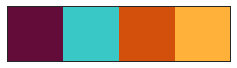

In [423]:
from __future__ import division, print_function, unicode_literals
import os
np.random.seed()

%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
#set style of plots
sns.set_style('white')

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [424]:
#df.get('2nr6iUHCilKUfyL9CicbQE', 'energy')

In [425]:
songs.head()

,id,artist,name,danceability,instrumentalness,energy,loudness,speechiness,acousticness,tempo,liveness,valence
0,2nr6iUHCilKUfyL9CicbQE,Steely Dan,Do It Again,0.683,0.000042,0.533,-10.253,0.0313,0.2060,124.571,0.0525,0.964
1,7kv7zBjMtVf0eIJle2VZxn,Glen Campbell,Southern Nights,0.697,0.023200,0.813,-8.890,0.0315,0.0989,95.301,0.5830,0.850
2,55GxhCTq6SY3tFTVh7z1nR,King Harvest,Dancing In The Moonlight,0.653,0.000000,0.719,-5.262,0.0363,0.6840,136.153,0.4080,0.682
3,3XF5xLJHOQQRbWya6hBp7d,Billie Eilish,you should see me in a crown,0.678,0.219000,0.533,-10.485,0.1860,0.4620,150.455,0.1390,0.323
4,3QzAOrNlsabgbMwlZt7TAY,Mustard,Ballin' (with Roddy Ricch),0.809,0.000000,0.545,-6.678,0.0735,0.3920,97.008,0.1510,0.244


In [426]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                449 non-null    object 
 1   artist            449 non-null    object 
 2   name              449 non-null    object 
 3   danceability      449 non-null    float64
 4   instrumentalness  449 non-null    float64
 5   energy            449 non-null    float64
 6   loudness          449 non-null    float64
 7   speechiness       449 non-null    float64
 8   acousticness      449 non-null    float64
 9   tempo             449 non-null    float64
 10  liveness          449 non-null    float64
 11  valence           449 non-null    float64
dtypes: float64(9), object(3)
memory usage: 42.2+ KB


In [427]:
songs.describe()

,danceability,instrumentalness,energy,loudness,speechiness,acousticness,tempo,liveness,valence
count,449.000000,449.000000,449.00000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,0.617138,0.130824,0.61208,-7.772873,0.108636,0.246571,120.276869,0.191633,0.461019
std,0.160764,0.274744,0.21128,3.807136,0.106111,0.292974,31.264298,0.153852,0.224704
min,0.135000,0.000000,0.01610,-25.358000,0.024700,0.000010,47.811000,0.021000,0.033700
25%,0.505000,0.000000,0.49100,-9.187000,0.039900,0.010400,94.582000,0.099000,0.282000
50%,0.624000,0.000146,0.61000,-7.072000,0.061600,0.116000,118.028000,0.128000,0.446000
75%,0.734000,0.041800,0.77500,-5.273000,0.128000,0.422000,141.863000,0.233000,0.620000
max,0.935000,0.955000,0.99700,-1.270000,0.568000,0.986000,213.900000,0.982000,0.975000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133cac640>,
      dtype=object)

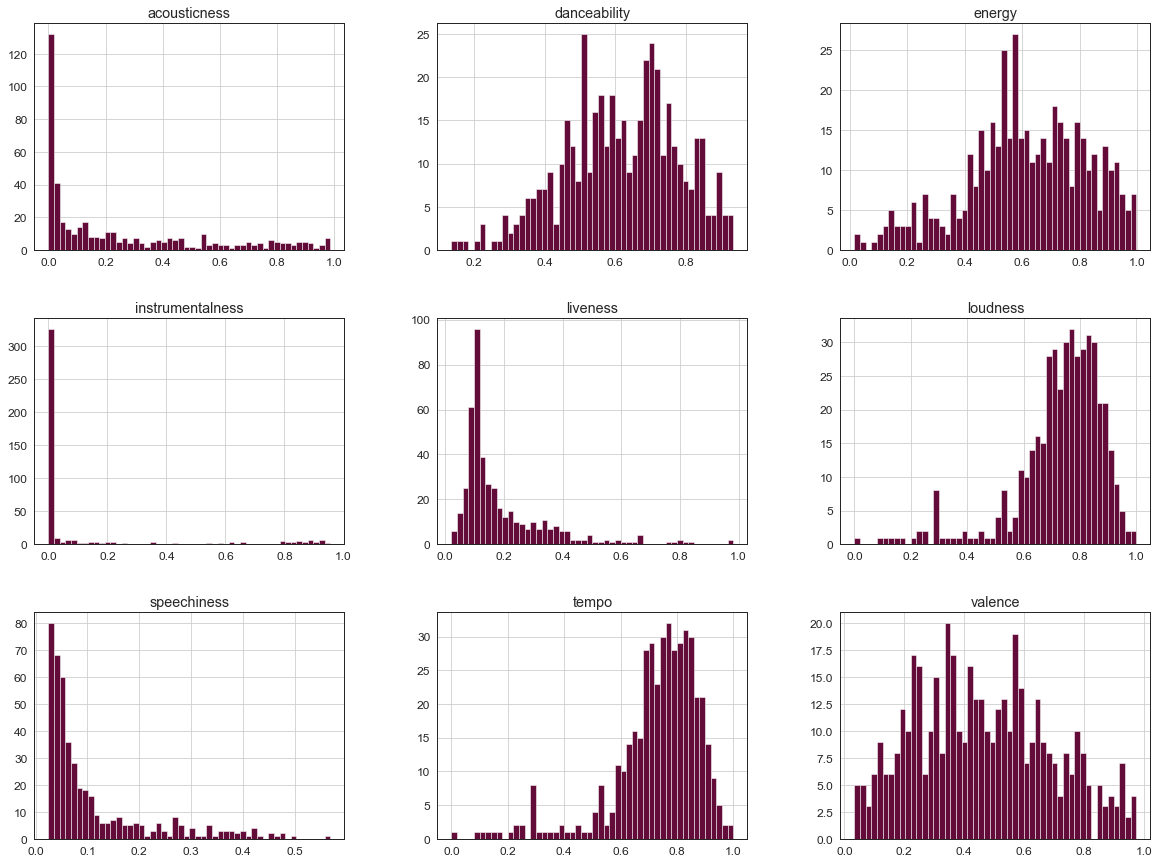

In [428]:
from sklearn import preprocessing

loudness = songs[['loudness']].values
min_max_scaler = preprocessing.MinMaxScaler()
loudness_scaled = min_max_scaler.fit_transform(loudness)
songs['loudness'] = pd.DataFrame(loudness_scaled)

tempo = songs[['tempo']].values
min_max_scaler = preprocessing.MinMaxScaler()
tempo_scaled = min_max_scaler.fit_transform(loudness)
songs['tempo'] = pd.DataFrame(tempo_scaled)


songs.hist(bins=50,figsize=(20,15))

In [429]:
# remove song names, artist and id before clustering
songs_features = songs.copy()
#songs_features = songs_features.drop(['name','artist','id'],axis=1)
songs_features = songs_features.drop(['id','instrumentalness','acousticness','name','artist','liveness'],axis=1)

In [430]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(songs_features)
    Sum_of_squared_distances.append(km.inertia_)

In [431]:
## TODO: For each score track the highest score within the range (2-15) !!Dont count for 1
from sklearn.metrics import silhouette_score
for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(songs_features)
    centers = clusterer.cluster_centers_

    score = silhouette_score (songs_features, preds, metric='euclidean')
    op_k = score
    if score < op_k:
        op_k = score
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
    #print(op_k)

For n_clusters = 2, silhouette score is 0.2790233791871161)
For n_clusters = 3, silhouette score is 0.2510610201099381)
For n_clusters = 4, silhouette score is 0.25481350299747685)
For n_clusters = 5, silhouette score is 0.23568416191271616)
For n_clusters = 6, silhouette score is 0.21689390453313623)
For n_clusters = 7, silhouette score is 0.20818293287627865)
For n_clusters = 8, silhouette score is 0.19945166893733735)
For n_clusters = 9, silhouette score is 0.20768885865767597)
For n_clusters = 10, silhouette score is 0.21595762847111483)
For n_clusters = 11, silhouette score is 0.20121944969840225)
For n_clusters = 12, silhouette score is 0.1993765270926714)
For n_clusters = 13, silhouette score is 0.20620893631965828)
For n_clusters = 14, silhouette score is 0.2017861809509407)


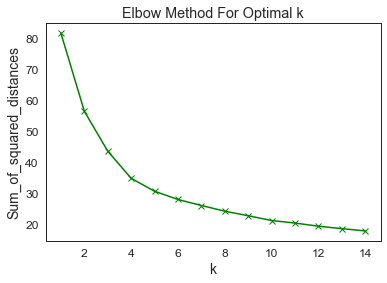

In [432]:
plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [433]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(songs_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [434]:
# PCA to reduce our data to 2 dimensions for visualisation
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(songs_features)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(songs_features)

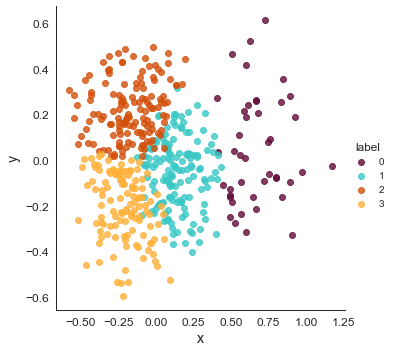

In [435]:
pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

In [436]:
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
#T-SNE with two dimensions
tsne = TSNE(n_components=2, perplexity=50)

tsne_components = tsne.fit_transform(songs_features)

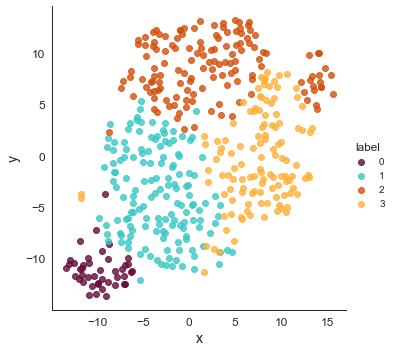

In [437]:
ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

In [438]:
print (pd.DataFrame(pca.components_,columns=songs_features.columns,index = ['PC-1','PC-2']))

      danceability    energy  loudness  speechiness     tempo   valence
PC-1      0.066038 -0.647401 -0.478291    -0.010195 -0.478291 -0.344793
PC-2      0.452030 -0.196774 -0.140812     0.056558 -0.140812  0.845041


In [439]:
#analyzing each cluster of data
df['label'] = y_kmeans

# shuffle dataset

df = df.sample(frac=1)
df['label'].value_counts()

1    147
2    139
3    120
0     43
Name: label, dtype: int64

In [ ]:
df[df['label'] == 0].tail(50)

In [ ]:
songs[songs['label']==1].head(15)

In [ ]:
songs[songs['label']==2].head(30)

In [ ]:
songs[songs['label']==3].head(40)

In [ ]:
df[df['label']==2].hist()

In [ ]:
songs[songs['label']==3].mean()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

X = songs_features
y = y_kmeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
rfc.fit(X_train,y_train)

In [ ]:
# Predicting the Test set results
y_pred = rfc.predict(X_test)